# Custom TransferLearning using MobileNetV2

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga de los datos para el entrenamiento

In [3]:
img_size = 224
batch_size = 32
path_train = 'data_' + str(img_size) + '/train'
path_test_validation = 'data_' + str(img_size) + '/validation'

In [4]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    path_train,
    target_size=(img_size, img_size),
    batch_size=batch_size)

val_generator = datagen_val.flow_from_directory(
    path_test_validation,
    target_size=(img_size, img_size),
    batch_size=batch_size)

Found 23975 images belonging to 5 classes.
Found 3028 images belonging to 5 classes.


## Mostrando los labels que van a ser entrenados

In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

labels = '\n'.join(sorted(train_generator.class_indices.keys()))
print(labels)

10
100
20
200
50


In [6]:
# numero de clases a entrenar
num_classes = len(train_generator.class_indices.keys())

In [7]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

# Empezando el entrenamiento

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

In [27]:
model = tf.keras.Sequential([
  base_model,
  Flatten(),
  BatchNormalization(),
  Dense(1024, activation='relu'),
  Dense(1024, activation='relu'),
  Dense(1024, activation='relu'),
  Dropout(0.2),
  Dense(512, activation='relu'),
  Dense(512, activation='relu'),
  Dense(512, activation='relu'),
  Dropout(0.2),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(num_classes, activation='softmax')
])

## Compilamos el modelo

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #default learning_rate = 0.001
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=metrics)

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62720)             250880    
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              64226304  
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)             

In [36]:
epochs = 10
history = model.fit(train_generator, 
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_generator)

Epoch 1/10
750/750 [==============================] - 39s 52ms/step - loss: 1.1776 - accuracy: 0.9945 - val_loss: 215.7457 - val_accuracy: 0.5304
Epoch 2/10
750/750 [==============================] - 39s 52ms/step - loss: 9.2375 - accuracy: 0.9907 - val_loss: 4388.6768 - val_accuracy: 0.4908
Epoch 3/10
750/750 [==============================] - 39s 52ms/step - loss: 1.3918 - accuracy: 0.9977 - val_loss: 217.1430 - val_accuracy: 0.4858
Epoch 4/10
750/750 [==============================] - 39s 52ms/step - loss: 0.2191 - accuracy: 0.9989 - val_loss: 228.8054 - val_accuracy: 0.5482
Epoch 5/10
750/750 [==============================] - 39s 52ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 237.4013 - val_accuracy: 0.5443
Epoch 6/10
750/750 [==============================] - 39s 52ms/step - loss: 0.0080 - accuracy: 0.9995 - val_loss: 299.7236 - val_accuracy: 0.5248
Epoch 7/10
750/750 [==============================] - 39s 52ms/step - loss: 0.0050 - accuracy: 0.9997 - val_loss: 320.2634 

## Creando un gráfico para la revisión

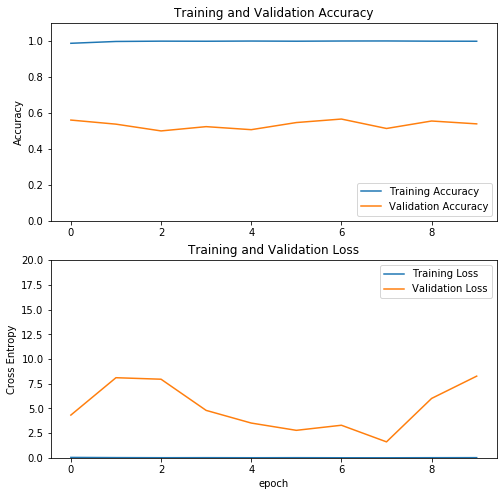

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Guardando el modelo

In [72]:
saved_model_dir = 'model_MobileNetV2'
tf.saved_model.save(model, saved_model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_MobileNetV2/assets


## Convirtiendo el modelo en tensorflow lite para el uso en mobile

In [73]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

path_tensorflow_lite = 'model_tflite/model_MobileNetV2.tflite'
with open(path_tensorflow_lite, 'wb') as f:
  f.write(tflite_model)

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 1515, num_label: 5, labels: 10, 100, 20, 200, 50.


INFO:tensorflow:Load image with size: 1515, num_label: 5, labels: 10, 100, 20, 200, 50.


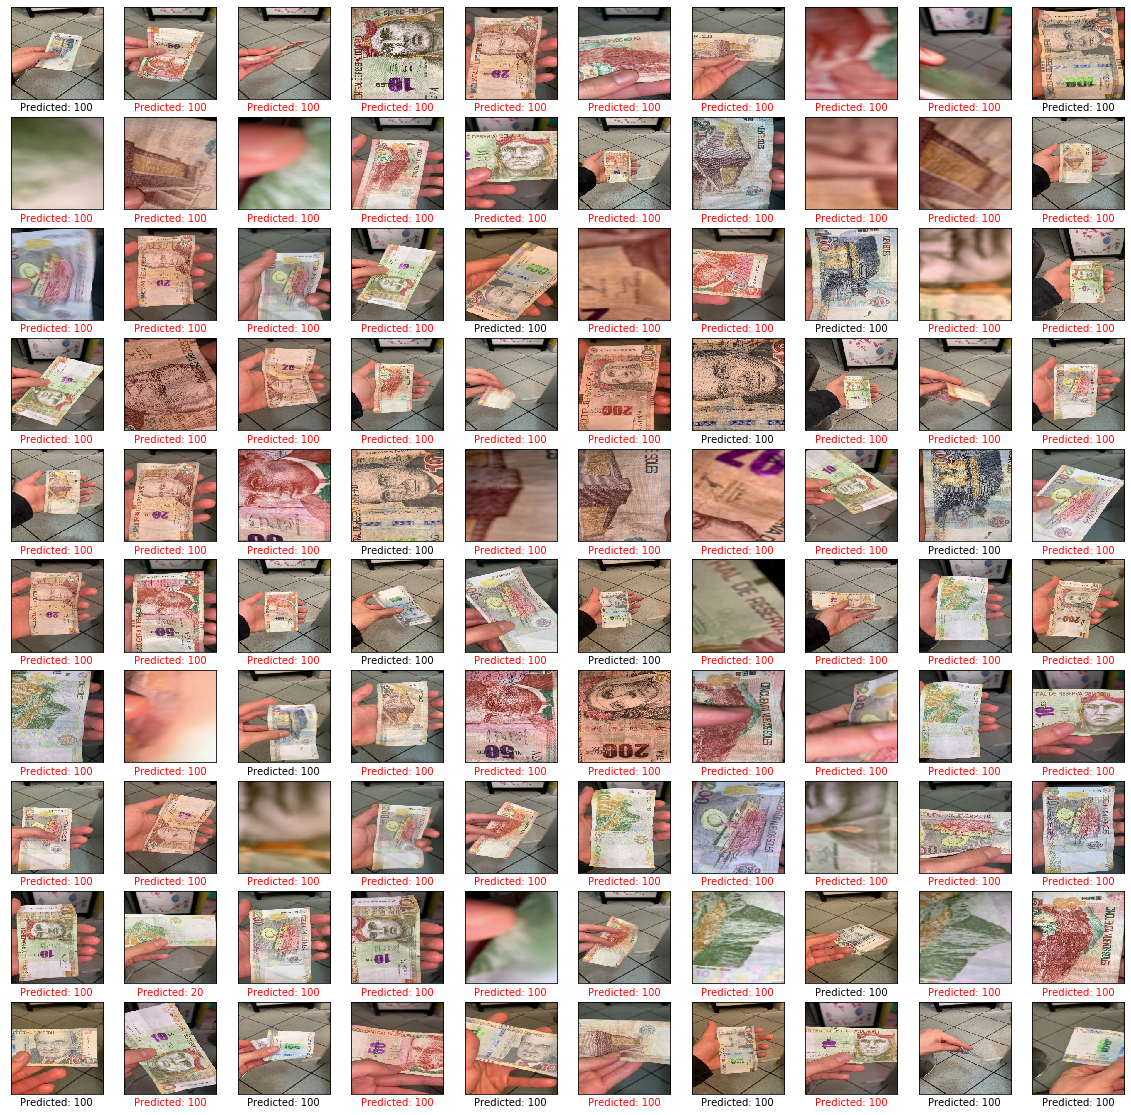

In [74]:
test_data = ImageClassifierDataLoader.from_folder(path_test_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    
    predict_label = "100"
    if id_predict == 1:
        predict_label = "20"
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()